In [50]:
import numpy as np 
import pandas as pd 
import time

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split


from IPython.display import clear_output
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d   ## smoother
from tqdm.notebook import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

/kaggle/input/lish-moa/test_features.csv
/kaggle/input/lish-moa/sample_submission.csv
/kaggle/input/lish-moa/train_features.csv
/kaggle/input/lish-moa/train_targets_scored.csv
/kaggle/input/lish-moa/train_targets_nonscored.csv


In [51]:
if torch.cuda.is_available():
    device='cuda'
else:
    device='cpu'
    
device

'cuda'

In [52]:
train_features = pd.read_csv('../input/lish-moa/train_features.csv')
train_targets_scored = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
train_targets_nonscored = pd.read_csv('../input/lish-moa/train_targets_nonscored.csv')
test_features = pd.read_csv('../input/lish-moa/test_features.csv')
submission = pd.read_csv('../input/lish-moa/sample_submission.csv')

In [53]:
def pre_process_data(train_features, train_targets_scored):
    
    feature_columns = list(train_features.columns[1:])
    target_columns = list(train_targets_scored.columns[1:])
    
    removal_list = ['cp_type', 'cp_dose']
    for x in removal_list:
        feature_columns.remove(x)
        
    train_cat = train_features.merge(train_targets_scored, on='sig_id')
    train_cat = train_cat.select_dtypes(exclude=['object'])
    
    dummy_df = train_cat.loc[:, train_cat.columns != 'sig_id']
    df_float = dummy_df.astype(float)
    scaler = MinMaxScaler()
    df_float_scaled = pd.DataFrame(scaler.fit_transform(df_float), columns = df_float.columns)
    df_float_scaled['sig_id'] = train_features['sig_id']
    return(df_float_scaled)

In [54]:
df_float_scaled = pre_process_data(train_features, train_targets_scored)
feature_columns = list(train_features.columns[1:])
removal_list = ['cp_type', 'cp_dose']
for x in removal_list:
    feature_columns.remove(x)
target_columns = list(train_targets_scored.columns[1:])

In [55]:
class TrainDataset(Dataset):
    def __init__(self, df, feature_columns, target_columns):
        
        self.features  = df[feature_columns].values
        self.targets = df[target_columns].values
        
    def sizes(self):
        print("features size = ", self.features.shape[1])
        print("targets size = ", self.targets.shape[1])

        
    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        feature = torch.tensor(self.features[idx]).float()
        target = torch.tensor(self.targets[idx]).float()
        
        return feature,target

In [56]:
full_dataset = TrainDataset(df_float_scaled, feature_columns, target_columns)

In [57]:
train_size = int(0.9 * len(full_dataset))  ## 90/10 split
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, num_workers = 8)

val_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle = True, num_workers = 8)

print(len(train_loader), "batches ")
print(len(val_loader), " batches ")

335 batches 
38  batches 


In [58]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
        
def show_lr(learning_rates):
    plt.plot(learning_rates, label = "learning rate")
    plt.ylabel("Learning rate", fontsize = 15)
    plt.grid(True)
    plt.legend()
    plt.show()
    
def show_deltas(deltas):
    deltas = gaussian_filter1d(deltas, sigma=3)
    plt.plot(deltas, "r", label = "Absolute error from label ")
    plt.ylabel("Error", fontsize = 15)
    plt.grid(True)
    plt.legend()
    plt.show()
    
def show_losses(loss_list):
    plt.plot(loss_list, 'r', label = 'Loss')
    plt.ylabel("Loss", fontsize = 15)
    plt.grid(True)
    plt.legend()
    plt.show()
    
def train_step(x, y, model, optimizer, criterion):
        optimizer.zero_grad()
        pred = model(x.to(device))
        y = y.float()
        loss = criterion(pred,y.to(device))
        loss.backward()
        optimizer.step()
        return loss.item()

In [59]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(873)
        self.dropout1 = nn.Dropout(0.2)
        self.dense1 = nn.utils.weight_norm(nn.Linear(873, 2048))
        
        self.batch_norm2 = nn.BatchNorm1d(2048)
        self.dropout2 = nn.Dropout(0.5)
        self.dense2 = nn.utils.weight_norm(nn.Linear(2048, 1048))
        
        self.batch_norm3 = nn.BatchNorm1d(1048)
        self.dropout3 = nn.Dropout(0.5)
        self.dense3 = nn.utils.weight_norm(nn.Linear(1048, 206))
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = F.relu(self.dense1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.relu(self.dense2(x))
        
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = (self.dense3(x))
        
        return x
    
    
model = Model()
print(model)
model = model.to(device)

Model(
  (batch_norm1): BatchNorm1d(873, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dense1): Linear(in_features=873, out_features=2048, bias=True)
  (batch_norm2): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (dense2): Linear(in_features=2048, out_features=1048, bias=True)
  (batch_norm3): BatchNorm1d(1048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (dense3): Linear(in_features=1048, out_features=206, bias=True)
)


In [60]:
losses = []
val_losses = []
learning_rates = []
average_deltas = []
val_corr=[]

optimizer = optim.Adam(model.parameters(), lr=1e-3)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min', 
                                                 factor=0.1, 
                                                 patience=3, 
                                                 eps=1e-4, 
                                                 verbose=True)
criterion = nn.BCEWithLogitsLoss()

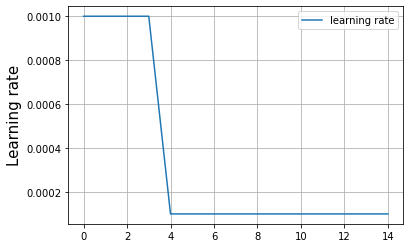

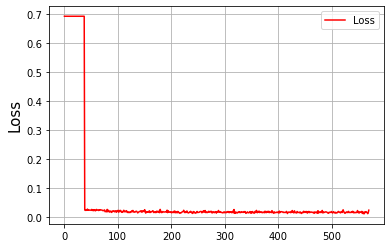

In [61]:
num_epochs=15
for epoch in range(num_epochs):
    
    clear_output(wait = True)
    show_lr(learning_rates)
    #show_deltas(average_deltas)
    show_losses(val_losses)
    
    total_loss = 0
    total_correct = 0
    total_loss2 = 0
    total_correct2 = 0
    
    print ("epoch ", epoch+1, " out of ", num_epochs )

    
    with torch.no_grad():
        model.eval()

        for x_val, y_val in tqdm(val_loader, desc = "running on test set --"):
            yhat =model(x_val.to(device))  # pred 
            #yhat = torch.round(torch.sigmoid(yhat))
            val_loss = criterion(yhat.to(device), y_val.to(device))
            val_losses.append(val_loss.item())  ## metrics 
            #average_deltas.append(torch.mean(torch.abs(yhat.cpu()-y_val.cpu())).item())


    model.train()
    for batch in tqdm(train_loader, desc = " Training batches : "):
        (x_batch, y_batch) = batch
        loss = train_step(x_batch.to(device), y_batch.to(device), model, optimizer, criterion)
        losses.append(loss)
    scheduler.step(1.)   ## lr decay caller 
    learning_rates.append(get_lr(optimizer))

    clear_output(wait = True)

    show_lr(learning_rates)
    show_losses(val_losses)
    #show_deltas(average_deltas)

In [62]:
test_df = pre_process_data(test_features, submission )

In [63]:
test_df.head()

,cp_time,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,...,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor,sig_id
0,0.0,0.311677,0.492348,0.425836,0.305543,0.564515,0.567412,0.476241,0.765565,0.537236,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,id_0004d9e33
1,1.0,0.335363,0.504033,0.538921,0.240668,0.426998,0.556299,0.339822,0.780791,0.535747,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,id_001897cda
2,0.0,0.359389,0.461120,0.433876,0.283037,0.349968,0.594606,0.466018,0.719682,0.593902,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,id_002429b5b
3,0.0,0.378813,0.499827,0.484694,0.304352,0.411180,0.498574,0.542799,0.731578,0.607347,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,id_00276f245
4,0.5,0.321330,0.331182,0.585233,0.288463,0.411115,0.577218,0.535683,0.800600,0.569840,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,id_0027f1083


In [64]:
test_dataset = TrainDataset(test_df, feature_columns, target_columns)

In [65]:
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False, num_workers = 8)

In [66]:
list_of_preds=[]
with torch.no_grad():
    model.eval()
    for x_test, y_test in tqdm(test_loader, desc = "running on test set --"):
        pred =model(x_test.to(device, dtype=torch.float))  # pred 
        pred = pred.cpu()
        pred = pred.sigmoid()
        list_of_preds.append(list(pred[0].numpy()))

In [67]:
submission = pd.read_csv('../input/lish-moa/sample_submission.csv')
sub_cp = submission
sub_cp.to_csv('./submission_cp.csv', index=None, header=True)

In [68]:
import csv 
a = list_of_preds  
with open('./submission_cp.csv', "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(a)

In [69]:
final_sub = pd.read_csv('./submission_cp.csv', header = None)
final_sub.head()

,0,1,2,3,4,5,6,7,8,9,...,196,197,198,199,200,201,202,203,204,205
0,-6.906514,-10.037319,-7.067277,-5.738963,-4.801744,-7.583585,-6.978337,-8.033804,-10.087412,-5.564300,...,-8.618535,-11.183626,-7.293645,-11.804387,-10.625091,-10.114108,-9.568006,-7.016848,-7.428362,-6.802690
1,-7.721139,-10.020224,-6.574782,-6.825776,-4.716693,-6.878952,-6.121612,-6.701095,-7.309774,-4.652847,...,-7.827489,-10.568341,-7.319203,-11.627129,-6.584890,-9.558182,-6.608545,-6.337615,-7.028562,-6.624512
2,-8.474200,-12.549698,-7.744347,-6.534324,-5.394559,-8.327050,-7.023392,-9.541793,-11.008221,-6.788436,...,-8.877191,-12.790099,-7.860549,-11.668090,-10.822981,-11.931119,-10.567121,-7.273679,-8.874907,-7.058156
3,-7.345932,-10.993735,-7.128180,-6.974970,-5.456245,-7.196219,-7.282748,-8.262154,-9.795920,-6.343618,...,-8.630685,-11.386888,-7.383839,-9.601575,-8.113172,-10.837913,-8.301046,-7.040994,-7.388807,-6.306052
4,-6.166151,-10.106408,-7.469214,-6.524183,-5.088352,-7.761166,-6.413837,-9.067953,-10.801625,-6.248049,...,-8.563482,-11.752374,-6.996154,-10.698910,-11.057872,-10.738637,-10.271218,-7.486642,-8.360163,-7.392129


In [70]:
final_sub.columns = submission.columns[1:]
final_sub["sig_id"] = submission["sig_id"]


In [71]:
final_sub.head()

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor,sig_id
0,-6.906514,-10.037319,-7.067277,-5.738963,-4.801744,-7.583585,-6.978337,-8.033804,-10.087412,-5.564300,...,-11.183626,-7.293645,-11.804387,-10.625091,-10.114108,-9.568006,-7.016848,-7.428362,-6.802690,id_0004d9e33
1,-7.721139,-10.020224,-6.574782,-6.825776,-4.716693,-6.878952,-6.121612,-6.701095,-7.309774,-4.652847,...,-10.568341,-7.319203,-11.627129,-6.584890,-9.558182,-6.608545,-6.337615,-7.028562,-6.624512,id_001897cda
2,-8.474200,-12.549698,-7.744347,-6.534324,-5.394559,-8.327050,-7.023392,-9.541793,-11.008221,-6.788436,...,-12.790099,-7.860549,-11.668090,-10.822981,-11.931119,-10.567121,-7.273679,-8.874907,-7.058156,id_002429b5b
3,-7.345932,-10.993735,-7.128180,-6.974970,-5.456245,-7.196219,-7.282748,-8.262154,-9.795920,-6.343618,...,-11.386888,-7.383839,-9.601575,-8.113172,-10.837913,-8.301046,-7.040994,-7.388807,-6.306052,id_00276f245
4,-6.166151,-10.106408,-7.469214,-6.524183,-5.088352,-7.761166,-6.413837,-9.067953,-10.801625,-6.248049,...,-11.752374,-6.996154,-10.698910,-11.057872,-10.738637,-10.271218,-7.486642,-8.360163,-7.392129,id_0027f1083


In [72]:
good_cols = np.roll(final_sub.columns.values, 1)
final_sub = final_sub[good_cols]

In [73]:
def scale_bw_0_1(df, immune_col):
    dummy_df = df.loc[:, df.columns != immune_col]
    df_float = dummy_df.astype(float)
    scaler = MinMaxScaler()
    df_float_scaled = pd.DataFrame(scaler.fit_transform(df_float), columns = df_float.columns)
    df_float_scaled[immune_col] = df[immune_col]
    
    good_cols = np.roll(df_float_scaled.columns.values, 1)
    final_sub = df_float_scaled[good_cols]
    
    return(final_sub)

scaled_sub = scale_bw_0_1(final_sub, 'sig_id')

In [74]:
final_sub.to_csv("./submission.csv", index=False)
final_sub

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,-6.906514,-10.037319,-7.067277,-5.738963,-4.801744,-7.583585,-6.978337,-8.033804,-10.087412,...,-8.618535,-11.183626,-7.293645,-11.804387,-10.625091,-10.114108,-9.568006,-7.016848,-7.428362,-6.802690
1,id_001897cda,-7.721139,-10.020224,-6.574782,-6.825776,-4.716693,-6.878952,-6.121612,-6.701095,-7.309774,...,-7.827489,-10.568341,-7.319203,-11.627129,-6.584890,-9.558182,-6.608545,-6.337615,-7.028562,-6.624512
2,id_002429b5b,-8.474200,-12.549698,-7.744347,-6.534324,-5.394559,-8.327050,-7.023392,-9.541793,-11.008221,...,-8.877191,-12.790099,-7.860549,-11.668090,-10.822981,-11.931119,-10.567121,-7.273679,-8.874907,-7.058156
3,id_00276f245,-7.345932,-10.993735,-7.128180,-6.974970,-5.456245,-7.196219,-7.282748,-8.262154,-9.795920,...,-8.630685,-11.386888,-7.383839,-9.601575,-8.113172,-10.837913,-8.301046,-7.040994,-7.388807,-6.306052
4,id_0027f1083,-6.166151,-10.106408,-7.469214,-6.524183,-5.088352,-7.761166,-6.413837,-9.067953,-10.801625,...,-8.563482,-11.752374,-6.996154,-10.698910,-11.057872,-10.738637,-10.271218,-7.486642,-8.360163,-7.392129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3977,id_ff7004b87,-5.897729,-8.385771,-6.747713,-6.251032,-4.392544,-6.843883,-6.524404,-6.725145,-8.192734,...,-7.818218,-9.833197,-6.372848,-8.910477,-6.743455,-9.007614,-6.869778,-6.520425,-6.830815,-6.672807
3978,id_ff925dd0d,-5.849936,-9.878220,-7.683170,-6.599363,-4.763426,-8.134160,-6.242714,-8.939557,-10.611772,...,-9.181347,-12.437528,-7.295601,-12.006838,-11.408297,-10.790997,-9.812609,-7.261048,-8.932777,-7.622788
3979,id_ffb710450,-6.224284,-10.551744,-8.068488,-6.824511,-4.265887,-7.380076,-6.474818,-8.895263,-10.927665,...,-9.211755,-12.886572,-8.232035,-12.193651,-10.788119,-11.253053,-11.619781,-7.776727,-9.224164,-7.647622
3980,id_ffbb869f2,-7.269462,-11.105717,-7.729827,-6.069247,-5.048457,-7.715062,-7.204977,-9.066048,-11.195934,...,-10.355356,-13.499394,-7.617971,-12.391840,-10.958365,-11.487015,-9.863905,-8.523955,-7.938643,-6.804509
